In [0]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import datetime
import os, sys, glob
plt.style.use('dark_background')

Using TensorFlow backend.


In [0]:
labels = pd.read_csv('/gdrive/My Drive/SCUT/train_test_files/All_labels.txt', sep=" ", header=None)
labels.head()

,0,1
0,CF437.jpg,2.883333
1,AM1384.jpg,2.466667
2,AM1234.jpg,2.150000
3,AM1774.jpg,3.750000
4,CF215.jpg,3.033333


In [0]:
labels_np = labels.values
print(labels_np[:5])

[['CF437.jpg' 2.8833330000000004]
 ['AM1384.jpg' 2.4666669999999997]
 ['AM1234.jpg' 2.15]
 ['AM1774.jpg' 3.75]
 ['CF215.jpg' 3.0333330000000003]]


In [0]:
imgs = np.empty((len(labels_np[:5]), 350, 350, 3), dtype=np.uint8)

for i, (img_filename, rating) in enumerate(labels_np[:5]):
    img = cv2.imread(os.path.join('/gdrive/My Drive/SCUT/Images', img_filename))
    
    if img.shape[0] != 350 or img.shape[1] != 350:
        print(img_filename)
        
    imgs[i] = img

In [0]:
imgs.shape

(5, 350, 350, 3)

In [0]:
x_train, x_val, y_train, y_val = train_test_split(imgs, labels_np[:5, 1], test_size=0.1)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(4, 350, 350, 3) (1, 350, 350, 3)
(4,) (1,)


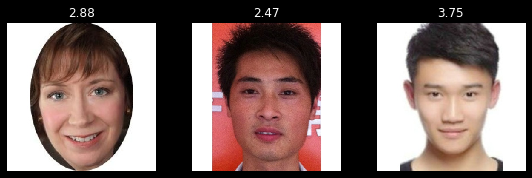

In [0]:
plt.figure(figsize=(16, 6))
for i, img in enumerate(x_train[:3]):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title('%.2f' % y_train[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=1,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)


In [0]:
np.array(train_generator)

array(<keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator object at 0x7f5d6749c940>,
      dtype=object)

In [0]:
augs = train_generator.__getitem__(1)

plt.figure(figsize=(16, 8))
for i, img in enumerate(augs[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f' % augs[1][i])
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

NameError: ignored

In [0]:
augs[].shape

(1,)

In [0]:
inputs = Input(shape=(350, 350, 3))

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(256)(net)
net = Activation('relu')(net)
net = Dense(128)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('linear')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 350, 350, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 350, 350, 32)      896       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 350, 350, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 175, 175, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 175, 175, 64)      18496     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 175, 175, 64)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 87, 87, 64)        0   

In [0]:
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
155/155 [==============================] - 126s 815ms/step - loss: 0.7363 - val_loss: 0.5486
Epoch 2/10
155/155 [==============================] - 125s 805ms/step - loss: 0.5579 - val_loss: 0.5390
Epoch 3/10
155/155 [==============================] - 125s 807ms/step - loss: 0.5462 - val_loss: 0.5105
Epoch 4/10
155/155 [==============================] - 125s 804ms/step - loss: 0.5229 - val_loss: 0.4624
Epoch 5/10
155/155 [==============================] - 125s 809ms/step - loss: 0.4949 - val_loss: 0.4905
Epoch 6/10
155/155 [==============================] - 126s 815ms/step - loss: 0.4667 - val_loss: 0.5035
Epoch 7/10
155/155 [==============================] - 125s 803ms/step - loss: 0.4572 - val_loss: 0.4122
Epoch 8/10
155/155 [==============================] - 126s 812ms/step - loss: 0.4281 - val_loss: 0.3721
Epoch 9/10
155/155 [==============================] - 123s 796ms/step - loss: 0.4202 - val_loss: 0.3679
Epoch 10/10
155/155 [==============================] - 122s 787m

In [0]:
pred = model.predict(x_val)

In [0]:
pred

array([[2.6632895],
       [3.0589843],
       [3.4462047],
       [3.4356782],
       [4.1304097],
       [2.400372 ],
       [2.9486928],
       [2.7344327],
       [2.5381851],
       [2.1778812]], dtype=float32)

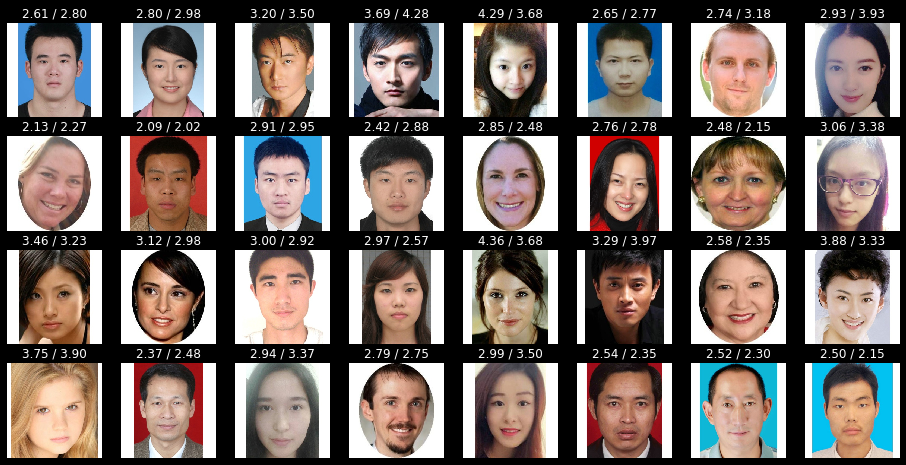

In [0]:
val_data = val_generator.__getitem__(0)

preds = model.predict(val_data[0])

plt.figure(figsize=(16, 8))
for i, img in enumerate(val_data[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f / %.2f' % (preds[i], val_data[1][i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

In [7]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [10]:
img_test_list = glob.glob('/iimmgg/*.jpg')

imgs_test_resized = []

plt.figure(figsize=(16, 8))
for i, img_path in enumerate(img_test_list):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (350, 350))

    plt.subplot(1, len(img_test_list), i+1)
    plt.axis('off')
    img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())
    
    img_resized = img_resized.astype(np.float32) / 255.
    imgs_test_resized.append(img_resized)

imgs_test_resized = np.array(imgs_test_resized, dtype=np.float32)

<Figure size 1152x576 with 0 Axes>

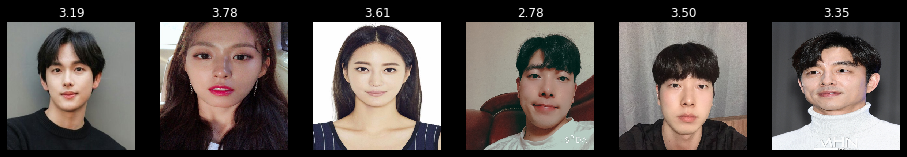

In [0]:
preds = model.predict(imgs_test_resized)

plt.figure(figsize=(16, 8))
for i, img in enumerate(imgs_test_resized):
    plt.subplot(1, len(imgs_test_resized), i+1)
    plt.title('%.2f' % (preds[i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())